In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/f1_2224.csv")
df.head()

,season,driver,team,wins,podiums,dnfs,constructor_rank,points,champion
0,2022,Verstappen,Redbull,15,17,2,1,454,1
1,2022,Leclerc,Ferrari,3,11,3,2,308,0
2,2022,Perez,Redbull,2,11,3,1,305,0
3,2022,Russell,Mercedes,1,8,1,3,275,0
4,2022,Sainz,Ferrari,1,9,7,2,246,0


In [3]:
team_map = {
    "Redbull": 0,
    "Ferrari": 1,
    "Mercedes": 2,
    "McLaren": 3,
    "Alpine": 4,
    "Haas": 5,
    "AlphaTauri": 6,
    "RB": 6,
    "AlfaRomeo": 7,
    "KickSauber": 7,
    "AstonMartin": 8,
    "Williams": 9
}

df["team_encoded"] = df["team"].map(team_map)
df.head()

,season,driver,team,wins,podiums,dnfs,constructor_rank,points,champion,team_encoded
0,2022,Verstappen,Redbull,15,17,2,1,454,1,0
1,2022,Leclerc,Ferrari,3,11,3,2,308,0,1
2,2022,Perez,Redbull,2,11,3,1,305,0,0
3,2022,Russell,Mercedes,1,8,1,3,275,0,2
4,2022,Sainz,Ferrari,1,9,7,2,246,0,1


In [4]:
feature_cols = ["wins", "podiums", "dnfs", "constructor_rank", "points", "team_encoded"]
target_col = "champion"
drivers = df["driver"]
teams   = df["team"]

In [5]:
#pandas to numpy

X_numpy = df[feature_cols].values
y_numpy = df[target_col].values

X_numpy.shape, y_numpy.shape

((68, 6), (68,))

In [6]:
#numpy to tensor

X = torch.from_numpy(X_numpy).float()
y = torch.from_numpy(y_numpy).float().unsqueeze(dim=1)

X.shape, y.shape

(torch.Size([68, 6]), torch.Size([68, 1]))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
drivers_train, drivers_test = train_test_split(drivers, test_size=0.2, random_state=42)

In [8]:
#normalize features
X_mean = X_train.mean(dim=0)
X_std = X_train.std(dim=0)

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

y_train, y_test = y_train.float(), y_test.float()

In [9]:
class ChampionPredictor(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=6, out_features=32)
    self.layer2 = nn.Linear(in_features=32, out_features=16)
    self.layer3 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
  
model_0 = ChampionPredictor()
print(model_0)

ChampionPredictor(
  (layer1): Linear(in_features=6, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [11]:
torch.manual_seed(42)
epochs = 500

#to plot loss curves
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  model_0.train()

  y_pred = model_0(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 25 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Training Loss: {loss} | Testing Loss: {test_loss}")

Epoch: 0 | Training Loss: 0.573563814163208 | Testing Loss: 0.573273241519928
Epoch: 25 | Training Loss: 0.4232887625694275 | Testing Loss: 0.43802976608276367
Epoch: 50 | Training Loss: 0.28320327401161194 | Testing Loss: 0.30575990676879883
Epoch: 75 | Training Loss: 0.16285932064056396 | Testing Loss: 0.18602535128593445
Epoch: 100 | Training Loss: 0.08689592778682709 | Testing Loss: 0.10258851945400238
Epoch: 125 | Training Loss: 0.04848023131489754 | Testing Loss: 0.05690959468483925
Epoch: 150 | Training Loss: 0.029252802953124046 | Testing Loss: 0.033679425716400146
Epoch: 175 | Training Loss: 0.019051004201173782 | Testing Loss: 0.02183270826935768
Epoch: 200 | Training Loss: 0.01334138959646225 | Testing Loss: 0.01537794154137373
Epoch: 225 | Training Loss: 0.009837889112532139 | Testing Loss: 0.011290575377643108
Epoch: 250 | Training Loss: 0.007556200958788395 | Testing Loss: 0.008629766292870045
Epoch: 275 | Training Loss: 0.005989802069962025 | Testing Loss: 0.006807805038

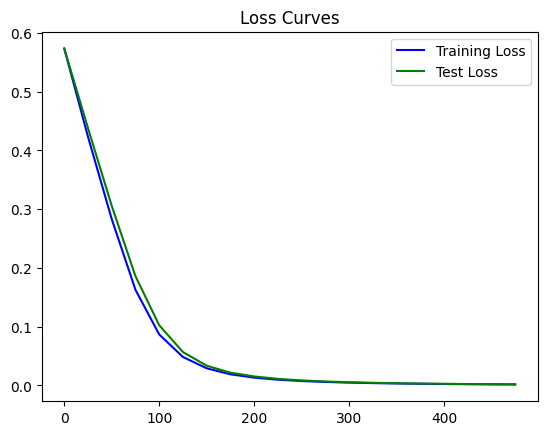

In [12]:
plt.plot(epoch_count, train_loss_values, label="Training Loss", c="blue")
plt.plot(epoch_count, test_loss_values, label="Test Loss", c="green")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [13]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

In [14]:
#converting logits to probabilities
probs = torch.sigmoid(y_preds)
#probabilities to labels 0 or 1
preds = (probs > 0.5).float()

In [15]:
for name, p in zip(drivers_test, preds):
  print(name, "->", int(p.item()))

Leclerc -> 0
Tsunoda -> 0
Sainz -> 0
Bottas -> 0
Sainz -> 0
Lawson -> 0
Magnussen -> 0
Hamilton -> 0
Bearman -> 0
Magnussen -> 0
Alonso -> 0
Bottas -> 0
Piastri -> 0
Verstappen -> 1


In [16]:
df = pd.read_csv("datasets/f1_25.csv")
df.head()

,season,driver,team,wins,podiums,dnfs,constructor_rank,points,champion
0,2025,Norris,McLaren,11,17,2,1,408,0
1,2025,Piastri,McLaren,7,15,2,1,392,0
2,2025,Verstappen,Redbull,7,14,1,3,396,0
3,2025,Russell,Mercedes,2,9,0,2,309,0
4,2025,Leclerc,Ferrari,0,7,3,4,230,0


In [17]:
team_map = {
    "Redbull": 0,
    "Ferrari": 1,
    "Mercedes": 2,
    "McLaren": 3,
}

df["team_encoded"] = df["team"].map(team_map)
df.head()

,season,driver,team,wins,podiums,dnfs,constructor_rank,points,champion,team_encoded
0,2025,Norris,McLaren,11,17,2,1,408,0,3
1,2025,Piastri,McLaren,7,15,2,1,392,0,3
2,2025,Verstappen,Redbull,7,14,1,3,396,0,0
3,2025,Russell,Mercedes,2,9,0,2,309,0,2
4,2025,Leclerc,Ferrari,0,7,3,4,230,0,1


In [18]:
X_25_numpy = df[["wins", "podiums", "dnfs", "constructor_rank", "points", "team_encoded"]].to_numpy()
X_25 = torch.from_numpy(X_25_numpy).float()

#normalizing again
X_25_norm = (X_25 - X_mean) / X_std

In [19]:
model_0.eval()
with torch.inference_mode():
  y_preds_25 = model_0(X_25_norm)

In [20]:
probs_25 = torch.sigmoid(y_preds_25)
preds_25 = (probs_25 > 0.5).float()

In [21]:
for driver, prob, pred in zip(df["driver"], probs_25, preds_25):
  print(f"{driver} -> Champion Probability (Individually) {float(prob)*100:.2f}%")

Norris -> Champion Probability (Individually) 97.54%
Piastri -> Champion Probability (Individually) 49.80%
Verstappen -> Champion Probability (Individually) 74.77%
Russell -> Champion Probability (Individually) 0.08%
Leclerc -> Champion Probability (Individually) 0.07%
Hamilton -> Champion Probability (Individually) 0.06%


In [22]:
logits_vec = y_preds_25.squeeze()
probs_softmax = torch.softmax(logits_vec, dim=0)

In [23]:
for driver, prob in zip(df["driver"], probs_softmax):
  print(f"{driver} -> {float(prob)*100:.2f}%")

Norris -> 90.93%
Piastri -> 2.27%
Verstappen -> 6.79%
Russell -> 0.00%
Leclerc -> 0.00%
Hamilton -> 0.00%


In [24]:
torch.save(model_0.state_dict(), "models/champion_predictor.pth")